In [13]:
from pandas_datareader import data as web
import numpy as np
import pandas as pd
from sklearn import mixture as mix
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

We start off by downloading all the required packages and then download the data using pandas_datareader package. One can also go for yfinance package for getting the data specifically from the yahoo finance website.

In [14]:
df= web.get_data_yahoo('AAPL',start= '2008-01-01', end='2017-08-01')
df=df[['Open','High','Low','Close']]

n = 10
t = 0.8
nh=15
split =int(t*len(df))

df['high']=df['High'].shift(1)
df['low']=df['Low'].shift(1)
df['close']=df['Close'].shift(1)

df['SMA']= df['close'].rolling(window=n).mean()    # Slow Moving Average
df['FMA']= df['close'].rolling(window=nh).mean()   # Fast Moving Average
df['MP'] = (df['Low'] + df['High'])/2              # Mid Point of the High and Low Price of the security
df['Corr']= df['SMA'].rolling(window=n).corr(df['close'])
df['Corr'][df.Corr>1]=1
df['Corr'][df.Corr<-1]=-1 
df['Return']= np.log(df['Open']/df['Open'].shift(1))

We then calculate the returns and create new features neessary for building a classification model.

In [15]:
df.shape

(2413, 12)

In [16]:
df.head(25)

,Open,High,Low,Close,high,low,close,SMA,FMA,MP,Corr,Return
Date,,,,,,,,,,,,
2008-01-02,28.467142,28.608572,27.507143,27.834286,NaN,NaN,NaN,NaN,NaN,28.057858,NaN,NaN
2008-01-03,27.915714,28.198572,27.527143,27.847143,28.608572,27.507143,27.834286,NaN,NaN,27.862858,NaN,-0.019561
2008-01-04,27.350000,27.571428,25.555714,25.721428,28.198572,27.527143,27.847143,NaN,NaN,26.563571,NaN,-0.020473
2008-01-07,25.892857,26.228571,24.318571,25.377142,27.571428,25.555714,25.721428,NaN,NaN,25.273571,NaN,-0.054749
2008-01-08,25.734285,26.065714,24.400000,24.464285,26.228571,24.318571,25.377142,NaN,NaN,25.232857,NaN,-0.006143
2008-01-09,24.471428,25.642857,24.042856,25.628571,26.065714,24.400000,24.464285,NaN,NaN,24.842856,NaN,-0.050318
2008-01-10,25.368572,25.857143,25.058571,25.431429,25.642857,24.042856,25.628571,NaN,NaN,25.457857,NaN,0.036005
2008-01-11,25.142857,25.407143,24.285715,24.670000,25.857143,25.058571,25.431429,NaN,NaN,24.846429,NaN,-0.008937
2008-01-14,25.360001,25.631428,25.024286,25.540001,25.407143,24.285715,24.670000,NaN,NaN,25.327857,NaN,0.008599


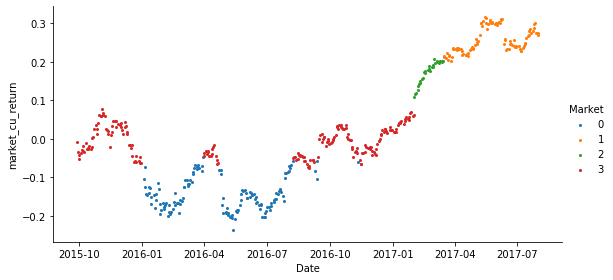

In [17]:
df.dropna(inplace=True)

ss= StandardScaler()
unsup = mix.GaussianMixture(n_components=4, 
                            covariance_type="spherical", 
                            n_init=50, 
                            random_state=17)

unsup.fit(np.reshape(ss.fit_transform(df[:split]),(-1,df.shape[1])))
mrkt = unsup.predict(np.reshape(ss.fit_transform(df[split:]),\
                                                   (-1,df.shape[1])))

Markets=pd.DataFrame(mrkt,columns=['Market'],index=df[split:].index)\
                     .join(df[split:], how='inner')\
                          .assign(market_cu_return=df[split:]\
                                  .Return.cumsum())\
                                  .reset_index(drop=False)\
                                  .rename(columns={'index':'Date'})

order=[0,1,2,3]
fig = sns.FacetGrid(data=Markets,hue='Market',hue_order=order,aspect=2,size= 4)
fig.map(plt.scatter,'Date','market_cu_return', s=4).add_legend()
plt.show()

We split the market into 4 regions depending upon the times of low mean-high covariance,high mean-high covariance,high mean-low covariance and low mean-low covariance regions. We also use train-test split to avoid overfitting of the model.

In [18]:
for i in order:
    print('Mean for regime %i: '%i,unsup.means_[i][0])
    print('Co-Variance for regime %i: '%i,(unsup.covariances_[i]))


ss1 =StandardScaler()
columns = Markets.columns.drop(['Market','Date'])    
Markets[columns]= ss1.fit_transform(Markets[columns])
Markets['Signal']=0
Markets.loc[Markets['Return']>0,'Signal']=1
Markets.loc[Markets['Return']<0,'Signal']=-1
Markets['return'] = Markets['Return'].shift(1)
Markets=Markets.dropna()

Mean for regime 0:  -1.07071022417271
Co-Variance for regime 0:  0.2613842571639955
Mean for regime 1:  1.7756911372403592
Co-Variance for regime 1:  0.2202828251721151
Mean for regime 2:  0.7045227131909647
Co-Variance for regime 2:  0.1961889533444029
Mean for regime 3:  -0.15005641346958978
Co-Variance for regime 3:  0.1790540082996532


In [23]:
maxv = -15000
max_c = 1.0
for c in [1.0,2.0,5.0,10.0]:
    cls= SVC(C=c, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)

    split2= int(.8*len(Markets))

    X = Markets.drop(['Signal','Return','market_cu_return','Date'], axis=1)
    y = Markets['Signal']

    cls.fit(X[:split2],y[:split2])

    p_data=len(X)-split2

    df['Pred_Signal']=0
    df.iloc[-p_data:,df.columns.get_loc('Pred_Signal')]=cls.predict(X[split2:])

    df['str_ret'] =df['Pred_Signal']*df['Return'].shift(-1)

    df['strategy_returns']=0.
    df['market_returns']=0.
    df.iloc[-p_data:,df.columns.get_loc('strategy_returns')] \
           = np.nancumsum(df['str_ret'][-p_data:])
    df.iloc[-p_data:,df.columns.get_loc('market_returns')] \
           = np.nancumsum(df['Return'][-p_data:])
    Sharpe = (df['strategy_returns'][-1]-df['market_returns'][-1])\
               /np.nanstd(df['strategy_returns'][-p_data:])
    
    if Sharpe > maxv:
        maxv = Sharpe
        max_c = c

print("The highest value of Sharpe ratio is {} for c ={}".format(maxv,max_c))
  #  plt.figure(figsize=(15,10))
  #  plt.plot(df['strategy_returns'][-p_data:],color='g',label='Strategy Returns')
   # plt.plot(df['market_returns'][-p_data:],color='r',label='Market Returns')
   # plt.figtext(0.14,0.9,s='Sharpe ratio: %.2f'%Sharpe)
  #  plt.legend(loc='best')
   # plt.show()

The highest value of Sharpe ratio is 0.11455910085377895 for c =2.0


In the last part, we hypertune our parameters i.e. 'c'. The best value of sharpe ratio helps determine the suitable value of 'c'.